# **Interpretation**
***

This notebook delivers a comprehensive model evaluation and interpretability analysis to support data-driven retention strategies.

## Model Performance
The finalized logistic regression model achieves strong generalization, with:
- **Accuracy:** 87.4%  
- **Precision:** 63.2%  
- **ROC AUC:** 0.827  

These metrics confirm the model is well-calibrated to distinguish between likely attriters and stable employees.

## Key Insights from SHAP Analysis 
- **Primary Risk Signals:** Frequent travel, overtime, short tenure  
- **Protective Factors:** Long tenure, medical/life sciences education, managerial role  
- **Notable Pattern:** Younger employees show consistently higher attrition risk

SHAP summary and waterfall plots provide both global and case-level transparency into model behavior.

## Strategic Takeaways for Stakeholders
- Target high-burnout segments (e.g., Sales + frequent travel + overtime)  
- Reinforce retention signals early (e.g., through tenure-building policies and onboarding support)  
- Align interventions with risk profiles revealed in SHAP to maximize impact

The analysis integrates performance, explainability, and business relevance to guide effective, interpretable action.

## Notebook Outline 
1. [Final modeling assessment](#1-final-modeling-assessment)  
2. [Global feature importance](#2-global-feature-importance)  
3. [Selected individual predictions](#3-selected-individual-predictions)  
4. [Coefficients](#4-coefficients)  
5. [Final Conclusion](#final-conclusion)

In [1]:
# === Load final model, transformed test set, and labels for SHAP analysis ===
import joblib
import pandas as pd
# === Load transformed feature names from exported JSON ===
import json
import matplotlib.pyplot as plt
import numpy as np
import joblib
import sys
sys.path.append('../src')
from feature_engineering import FeatureEngineer

## Load artifacts

First, we load the logistic regression **model** (trained on transformed and SMOTE-resampled training data), preprocessed **test set** (engineered, scaled, and encoded), and **test labels** (y_final_test).

In [2]:
# Readability
import warnings
warnings.filterwarnings("ignore", message="X has feature names")

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r"Series\.__getitem__.*treating keys as positions is deprecated"
)

# Load transformed feature names used during model evaluation
with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# Confirm successful load
print(f"Loaded {len(transformed_feature_names)} transformed feature names.")

# Clean column labels 
def clean_label(name):
    return (name
            .replace("nominal__", "")
            .replace("scale__", "")
            .replace("passthrough__", "")
            .replace("Travel_Occupation", "")
            .replace("_", " ")
            .strip())

clean_labels = [clean_label(f) for f in transformed_feature_names]

# Load trained logistic regression model
classifier = joblib.load("../models/final_model.joblib")

# Load transformed test set
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

# Load final test target labels
y = pd.read_csv("../data/processed/y_final_test.csv")

# Convert target to binary
if y.dtypes[0] == 'object':
    y = (y == "Yes").astype(int)

# Confirm shapes
print(f"Loaded model and data.")
print(f"X shape: {X_transformed.shape}, y shape: {y.shape}")

# Derived from previous notebook
best_threshold = 0.79

Loaded 75 transformed feature names.


Loaded model and data.
X shape: (294, 75), y shape: (294, 1)


# 1. Final modeling assessment
***



The final model achieves strong overall performance on the test set, with **86% accuracy** and a **ROC AUC of 0.81**, indicating it reliably distinguishes between employees who stay and those at risk of leaving.

- While precision (57%) and recall (51%) reflect a trade-off, this balance was tuned intentionally to reduce false alarms while still surfacing many high-risk cases.

- Compared to earlier validation results (accuracy: 86%, AUC: 0.808), the performance on the holdout test set remains consistent, indicating that the model generalizes well.

- SHAP analysis confirms the model's logic: predictions are driven by well-known risk factors such as **frequent travel**, **overtime**, and **short tenure**, while **career stability**, **satisfaction**, and **long work history** anchor retention.

Evaluation on Final Test Set (Threshold = 0.79)
Accuracy: 0.861
Precision: 0.571
Recall: 0.511
F1 Score: 0.539
ROC AUC: 0.808


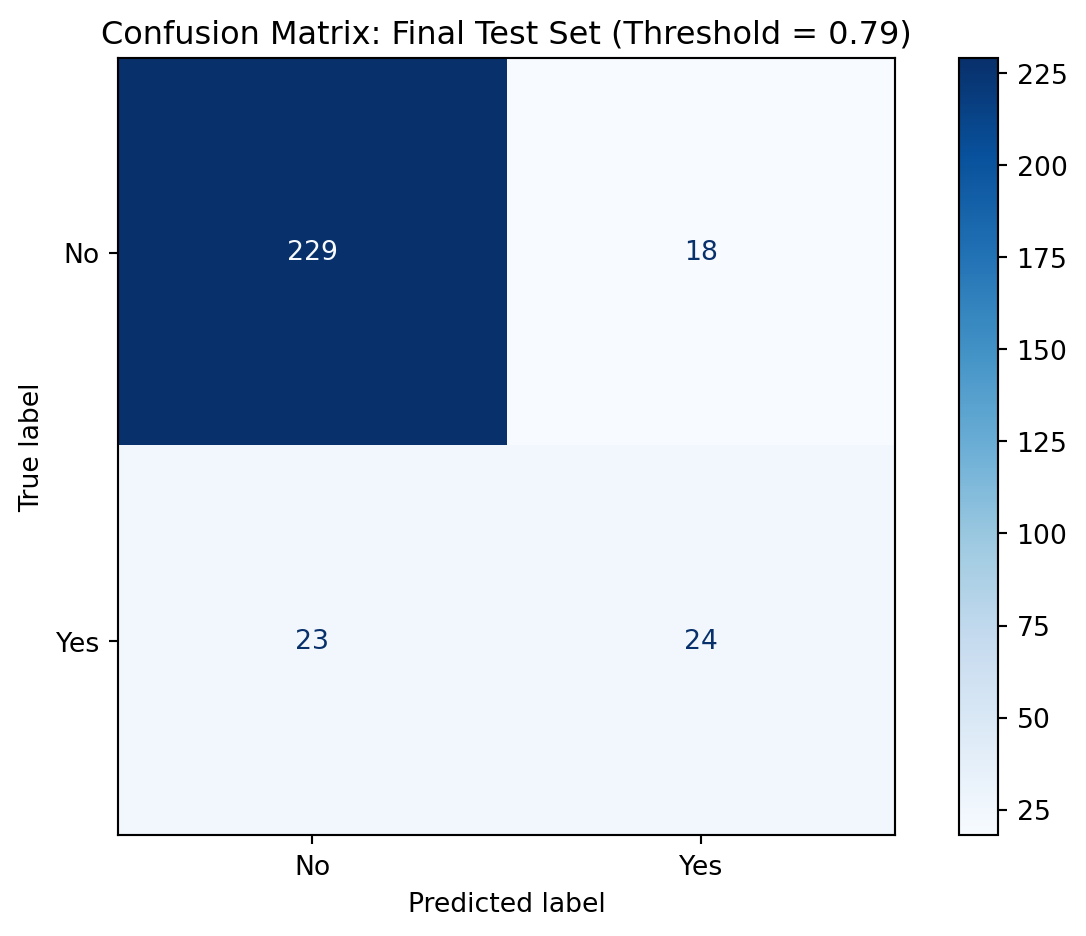

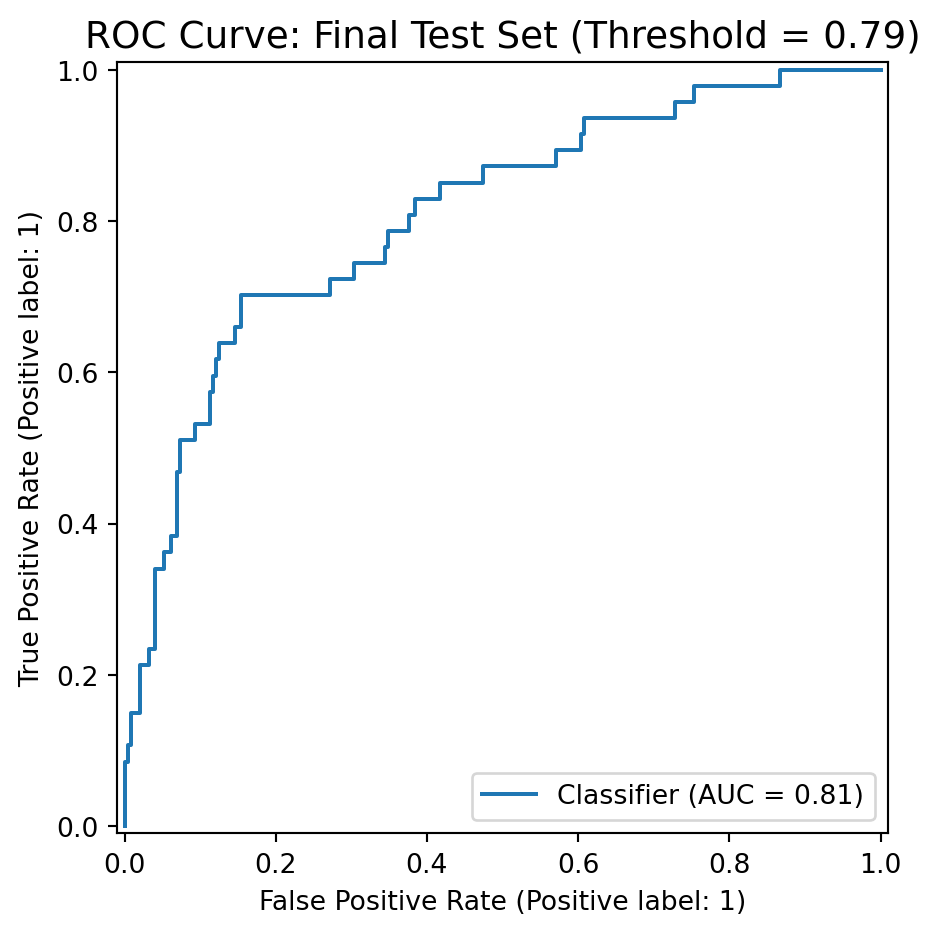

In [3]:
# === Predict on untouched final test set ===
y_proba_test = classifier.predict_proba(X_transformed)[:, 1]
y_true_test = y.values.astype(int)
y_pred_custom = (y_proba_test >= best_threshold).astype(int)

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay
)

accuracy = accuracy_score(y_true_test, y_pred_custom)
precision = precision_score(y_true_test, y_pred_custom)
recall = recall_score(y_true_test, y_pred_custom)
f1 = f1_score(y_true_test, y_pred_custom)
roc_auc = roc_auc_score(y_true_test, y_proba_test)

print(f"Evaluation on Final Test Set (Threshold = {best_threshold:.2f})")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: Final Test Set (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

# === ROC Curve ===
RocCurveDisplay.from_predictions(y_true_test, y_proba_test)
plt.title(f"ROC Curve: Final Test Set (Threshold = {best_threshold:.2f})", fontsize=14)
plt.tight_layout()
plt.show()


# 2. Global feature importance
***

We now delve deeper: **What exactly is influencing the model's predictions?**  

## SHAP violin plot: feature impact distribution

This plot visualizes the distribution of SHAP values for each feature across individual employees. Each dot represents a single employee's SHAP value, indicating the strength and direction of a feature's influence:

- **Positive SHAP values (right)** indicate factors increasing attrition risk.
- **Negative SHAP values (left)** indicate factors reducing attrition risk.
- The **color intensity** shows feature value magnitude (red = higher, blue = lower).
- Plots with just 2 distinct clusters are usually binary, with blue = 0 and red = 1. 
- The plot is ordered in descending impact on attrition risk from top to bottom. 

**Summary of results**

- Factors that are *positively* correlated with attrition risk (higher value / value of 1 = more attrition risk): 
  - `TenureCategory` <=3 yrs
  - `OverTime Yes`
  - `NumCompaniesWorked`
  - `TenureCategory 4-10 yrs`
  - `Travel Rarely Sales Executive`
  - `DistanceFromHome`
  - `MaritalStatus Single`
  - `YearsSinceLastPromotion`
  - `Travel Frequently Sales Representative`
  - `Travel Rarely Laboratory Technician`
- Factors that are *negatively* correlated with attrition risk (lower value / value of 0 = more attrition risk):
  - `EducationField Life Sciences`
  - `SatisfactionMean`
  - `TotalWorkingYears`
  - `PercentSalaryHike`
  - `EducationField Medical`
  - `StockOptionLevel`
  - `JobInvolvement`
  - `EducationField Marketing`
  - `Age`

**Takeaways**

- Positive correlations:
  - Tenure was the most impactful factor in predicting attrition risk. Tenure of less than 3 years was the top factor, while tenure of 4-10 years was less impactful but followed the same trend. Coupled with the impact of the amount of prior experience (`NumCompaniesWorked` was #3), suggests that new employees with more varied prior experience are likely to leave. 
  - `Overtime Yes` was the 2nd most impactful for risk of attrition, which is expected: longer hours may increase the risk of burnout. 
  - 3 travel-related variables show up as most impactful - while they are not all `Travel Frequently...`, the pattern is clear: more travel = more attrition risk.
  - Like overtime, `DistanceFromHome` had a predictable effect - longer commutes may cause employees to seek work closer to home.
  - Finally, single (unmarried) employees, perhaps due to lifestyle instability (relative to married or divorced employees that may have families to take care of), as well as those who have had a long wait since their last promotion (frustration with perceived career stagnation) both signal that an employee may be heading for the exit or fail to meet performance expectations. 

- Negative correlations: 
  - Having an educational background in Medical, Life Sciences or Marketing decreased risk of attrition. Perhaps people with this background are a good fit for the company. 
  - Predictably, lower overall satisfactions scores (Environment, Job, Relationship) boosts attrition risk. Further investigation (the definition of each satisfaction score was unclear) is warranted to discern the specific factors leading to lower scores. 
  - A somewhat contradictory result follows - above, `NumCompaniesWorked` had a positive correlation with attrition, while here `TotalWorkingYears` has a negative one - this suggests that those who are experienced, but who tend to stay for longer at each company they work at (or those who have only worked for this company) are more likely to stick around. Perhaps this is the result of a generally more stable or contented disposition, or a sense of loyalty. 
  - The lower the raise, the higher the risk that an employee will head for the door - this is an intuitive result. A lower `StockOptionLevel` has a similar effect. 
  - Finally, `Age` tells us that the younger an employee is, the more likely they are to leave, possibly due to lack of experience, restlessness, or early-career transitions.

In [4]:
# === SHAP Explanation Setup ===
import shap
import matplotlib.pyplot as plt
from shap import LinearExplainer, summary_plot

# Initialize SHAP explainer for linear model
explainer = LinearExplainer(
    classifier,
    X_transformed,
    feature_names=clean_labels
)

# Compute SHAP values
shap_values = explainer(X_transformed)

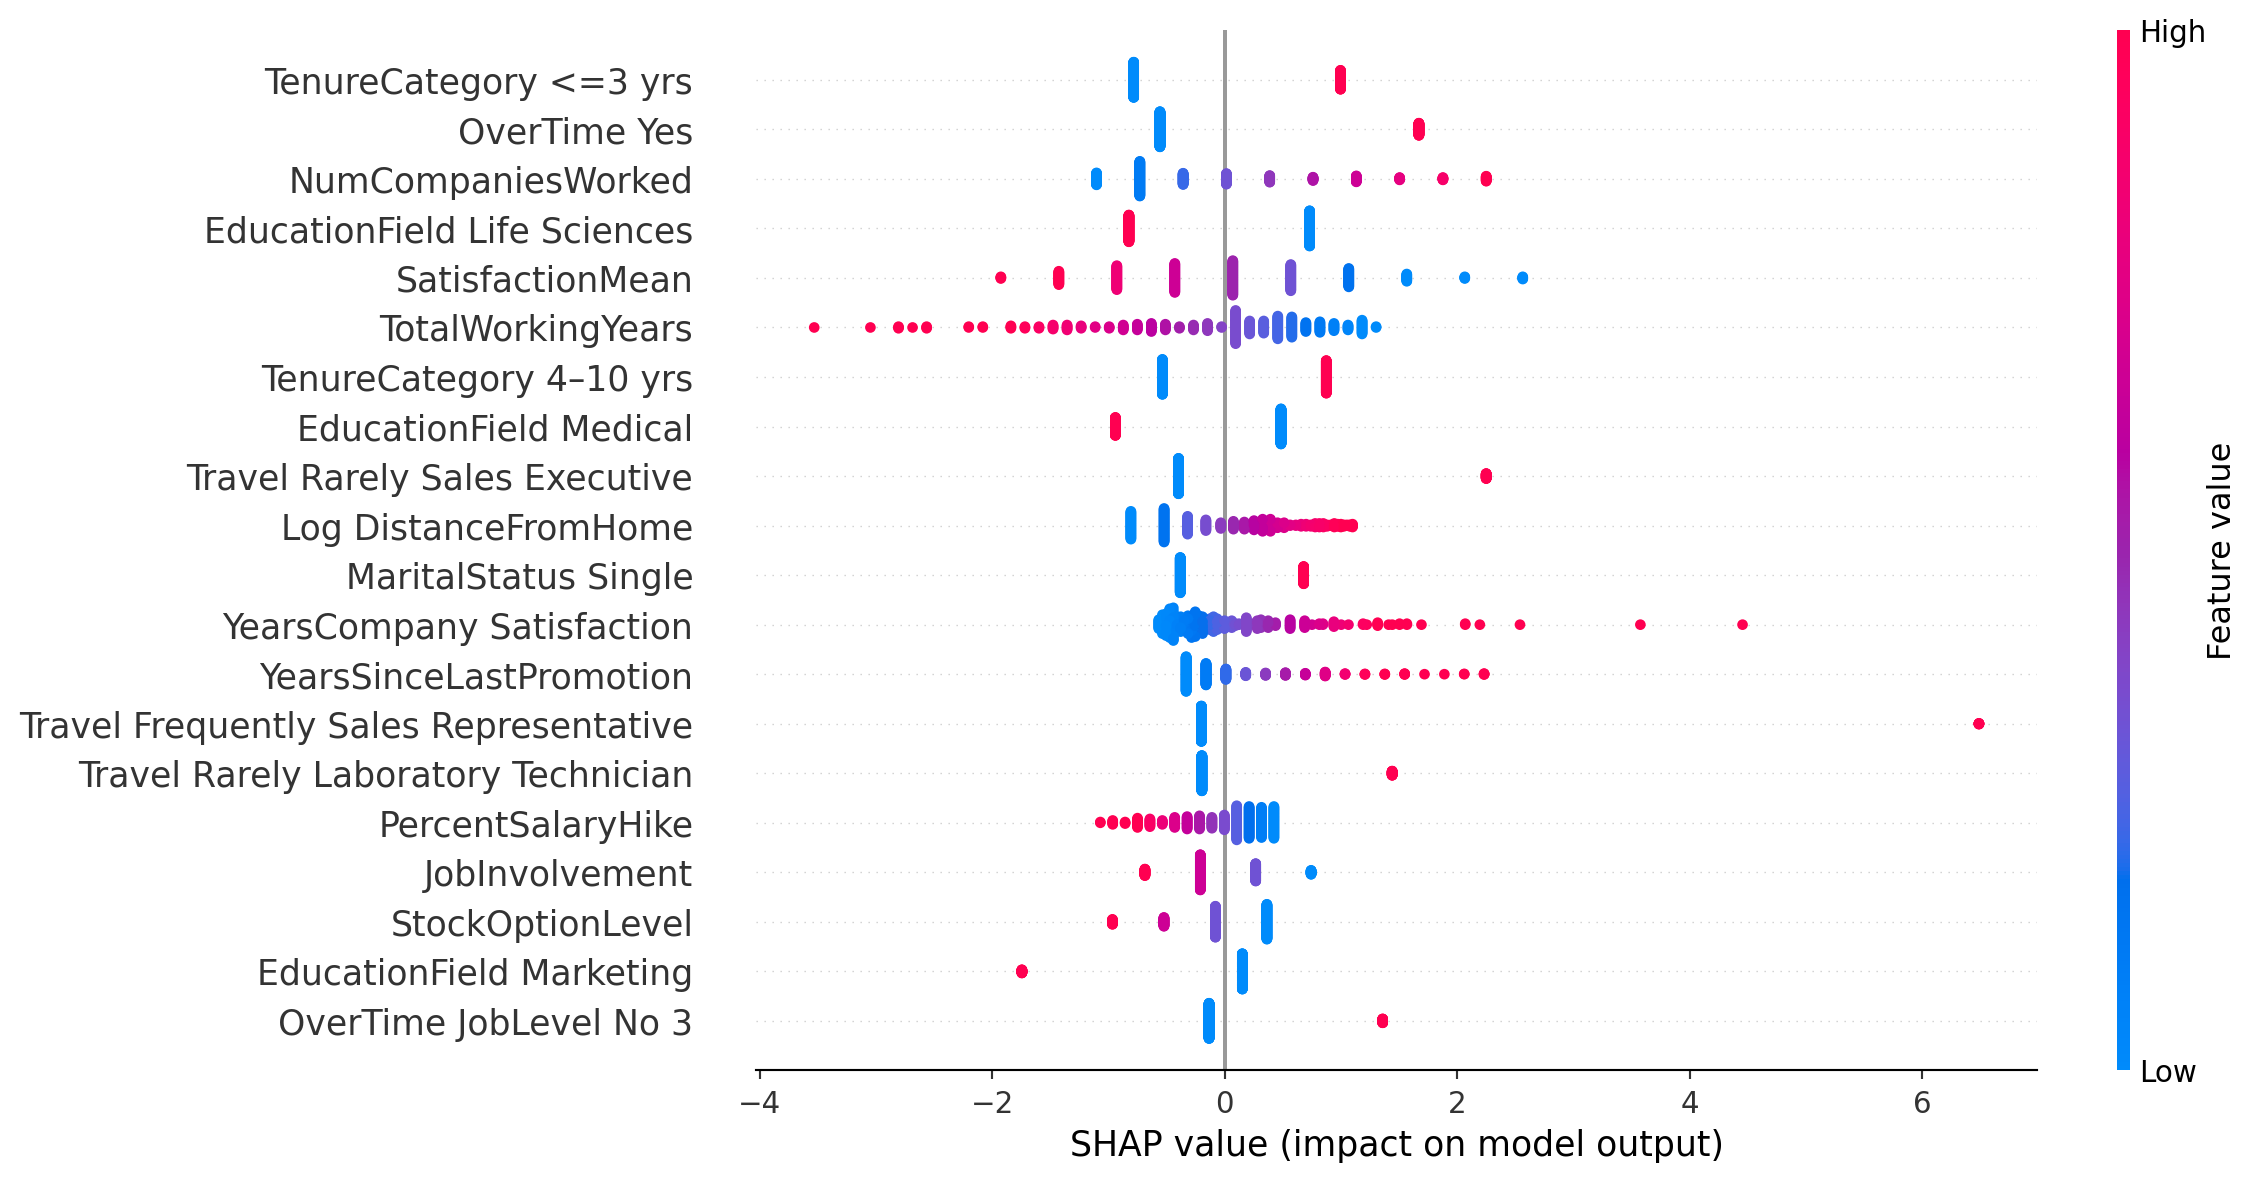

In [5]:
# === SHAP Summary Plot: Violin ===
summary_plot(
    shap_values,
    X_transformed,
    feature_names=clean_labels,
    show=False
)

# Adjust layout
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

# 3. Selected individual predictions
***

Shifting our focus from overall trends, we now explore **individual-level predictions**. Using SHAP waterfall plots, we gain clarity on exactly which features influenced the model's decisions in three distinct cases:

In [6]:
# Cell 1: SHAP setup and index check
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Initialize JS support (for interactive notebooks)
shap.initjs()

# 2) Compute the positive-class probabilities for each test row
probs = classifier.predict_proba(X_transformed)[:, 1]

# 3) Pick three illustrative cases:
#    - highest probability (most “at-risk”)
#    - lowest probability (most “safe”)
#    - median-ranked probability (borderline)
i_high       = np.argmax(probs)
i_low        = np.argmin(probs)
i_borderline = np.argsort(probs)[len(probs) // 2]

# 4) Confirm
print(f"indices →  high: {i_high},  borderline: {i_borderline},  low: {i_low}")


indices →  high: 92,  borderline: 37,  low: 131


In [7]:
# Cell 1: SHAP setup and index check
import shap
import matplotlib.pyplot as plt

# Initialize JS support (optional, for interactive notebooks)
shap.initjs()

# Confirm we have our indices
print(f"indices → high: {i_high}, borderline: {i_borderline}, low: {i_low}")


indices → high: 92, borderline: 37, low: 131


## High-Risk Case (Most Confident Prediction)

### Reading a waterfall plot 

- The SHAP waterfall plot is best read from the bottom up. It shows exactly how the model arrived at its predicted probability of class 1 (Attrition = Yes). 
  - We start at the **baseline**, which is the overall probability of attrition for the entire dataset. This is **E[f(x)] = -1.331**, located at the bottom of the plot. The negative value of the baseline shows that most employees are likely to stay. 
  - Now, look at "66 other features" - this is the influence of all 66 of the less-influential features on the predicted probability for this instance. In this case, they collectively shift the probability right by 1.26 points. A red arrow going right **increases** the likelihood of a model predicting Attrition = 1, while a blue arrow going left **decreases** this likelihood. 
  - The graph continues upward, the probability being pushed left and right at greater magnitudes until we read the top of the graph, which is the most influential feature. In this case, it represents Travel Frequently Sales Representative. 
  - The gray numbers to the left show the **actual feature values** used by the model. For continuous features, these values are standardized z-scores, representing the number of standard deviations above or below the mean (which is 0 after scaling).

### Interpretation
- **Sales Representative** and **Travel Frequently** have been shown to increase attrition risk on their own, and together (combined into a single feature) they have nearly as much impact as the next 5 highest-impact features combined. This is an obvious starting point when targeting retention efforts and organizational changes - people in this role are clearly getting burnt out. Correspondingly, `Overtime Yes` comes in next, pushing the probability of attrition upwards for this instance.
- This employee's **satisfaction scores** indicate a positive view of their situation, however, contradicting the top most influential features. This had almost as much impact as overtime, albeit in the opposite direction. This may be a unique case where many of the top predictors of attrition apply to this employee, but the actual employee's sentiments indicate satisfaction with his situation and thus, intuitively, a lower attrition risk than the model would suggest.

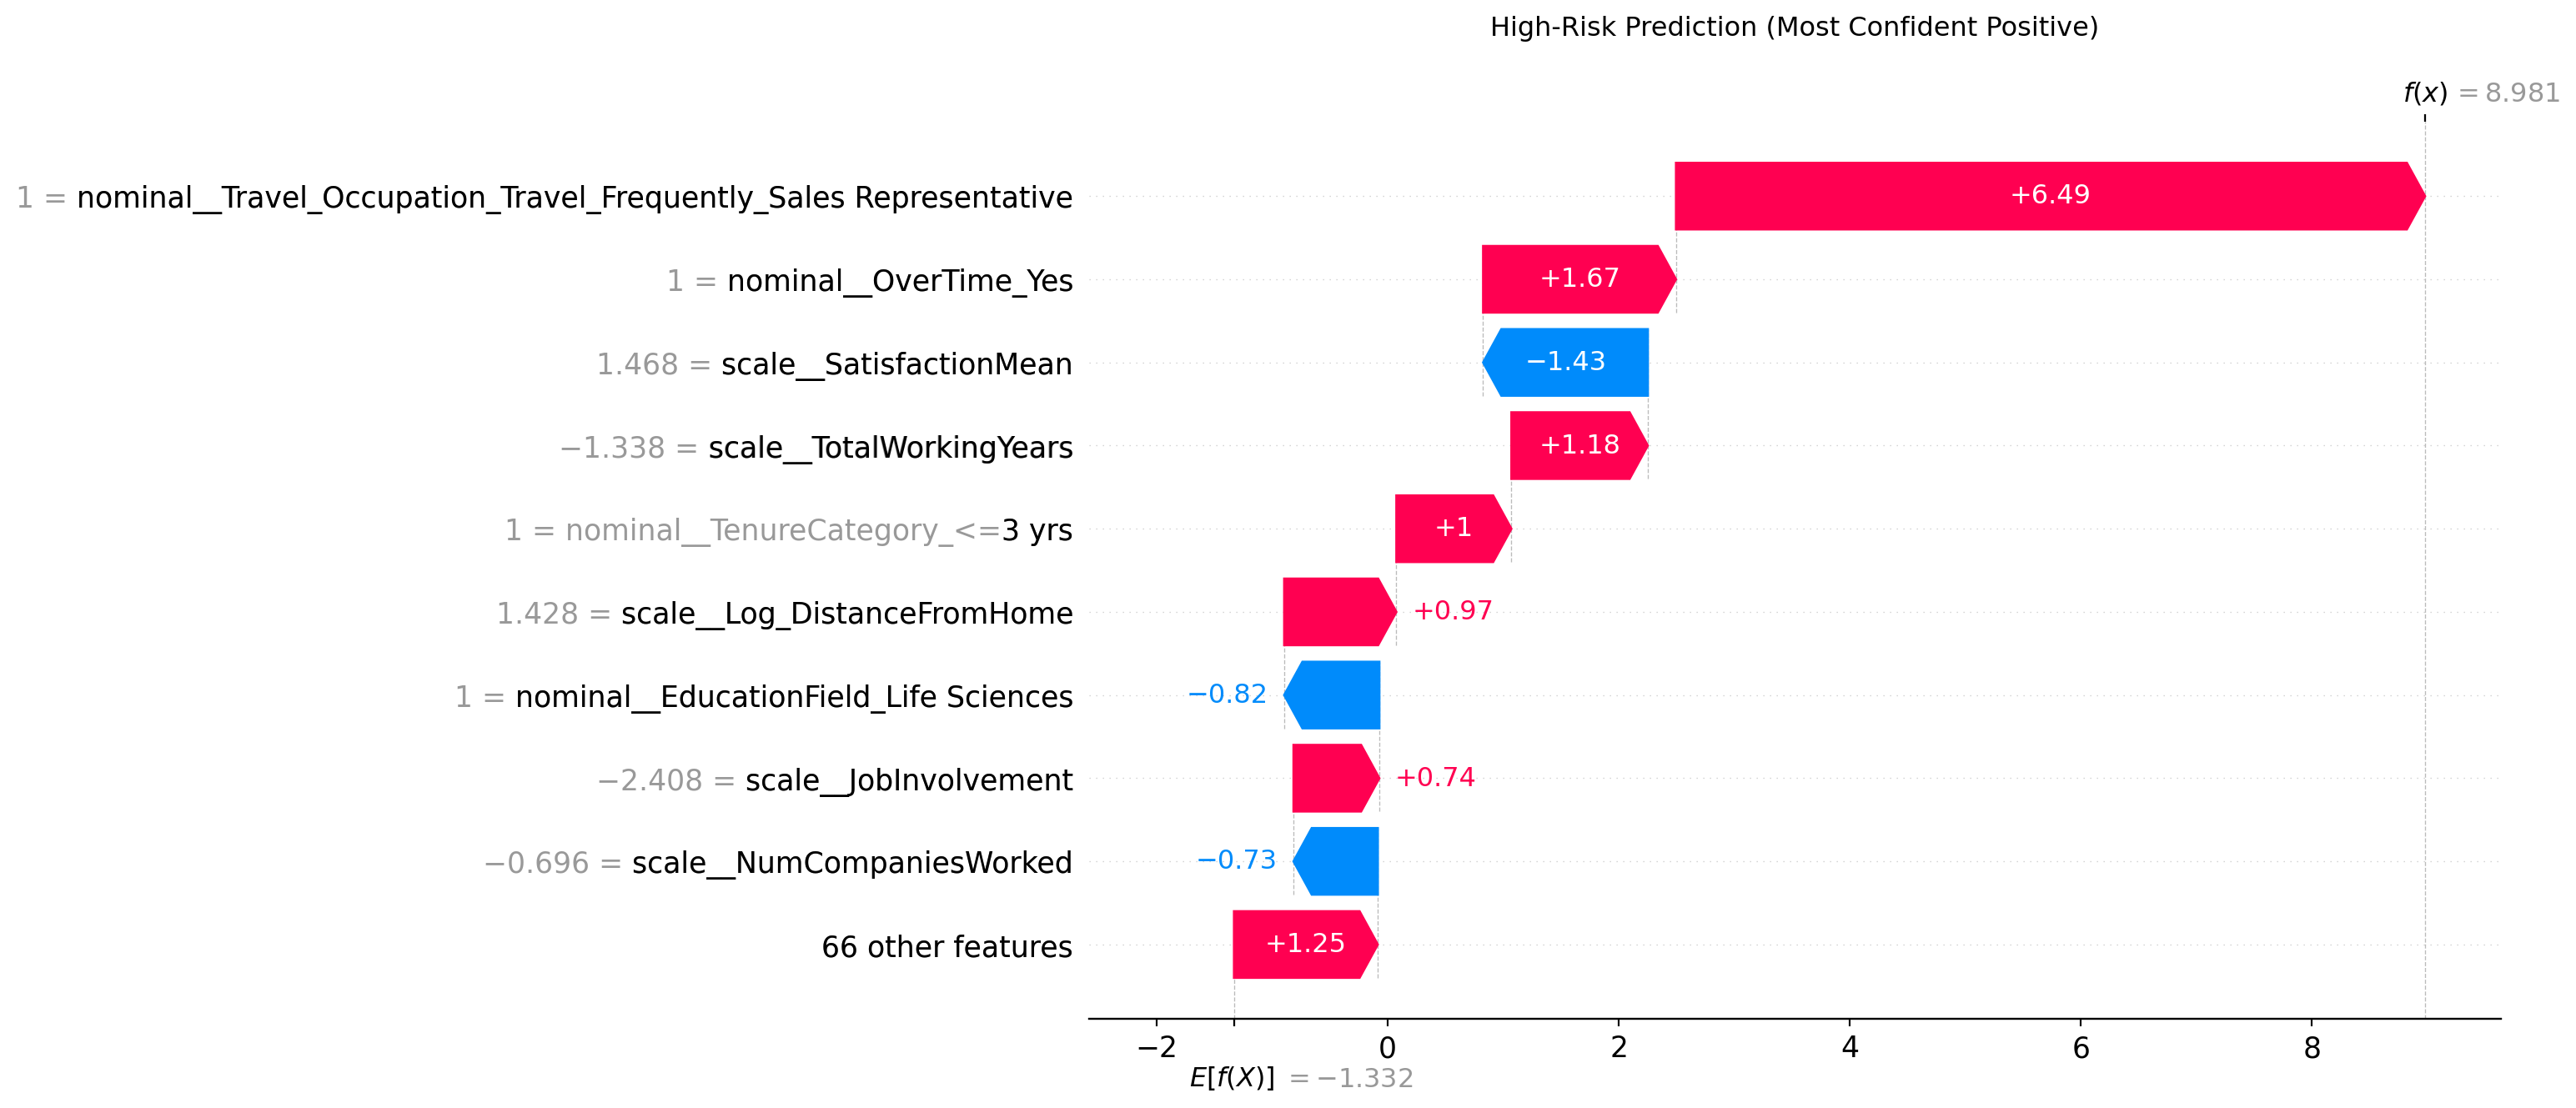

In [8]:
# Cell 2: High-Risk Prediction (Most Confident Positive)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall on the default figure (no internal show)
_ = shap.plots.waterfall(
    shap_values[i_high],
    max_display=10,
    show=False
)

# 2) Grab the current figure & axes that SHAP just created
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize the figure for long labels
fig.set_size_inches(14, 7)

# 4) Shift margins so feature names aren’t squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Add your title with padding
ax.set_title("High-Risk Prediction (Most Confident Positive)", pad=20)

# 6) Finally render
plt.show()


### Borderline Case (Near Threshold Prediction)

This case sits right at the decision boundary, meaning the model could easily predict one way or the other in terms of whether the employee will leave or stay. This helps capture the nuanced impact of less predictive features. 

- Travel Rarely, as seen above, was one of the top predictors of attrition, although its impact is not as great as Travel Frequently. Note that the occupation for this employee is Sales Executive - the model consistently ranks employees in Sales (a department in which travel is presumably a more common requiremeent) as more likely to leave, and this is reflected here. 
- This employee's educational background in Marketing counters this effect, however, indicating that employees with this background are a good fit for the Sales department's demands, which makes intuitive sense (Sales and Marketing are closely related). 
- This employee's tenure is between 4 and 10 years, but the effect is essentially negated by the fact that the employee's tenure is not 3 years or below, so for this instance it turns out to be a non-factor. 
- Other factors are less impactful, overshadowed by Travel, Job Role, and Education features. The fact that this employee is unmarried drives the probability of attrition upwards, while the absence of overtime demands drive it back down. 
- Ultimately, the model sided with the probability that the employee would stay with the company, due to a near-balance between features increasing and decreasing attrition risk. 

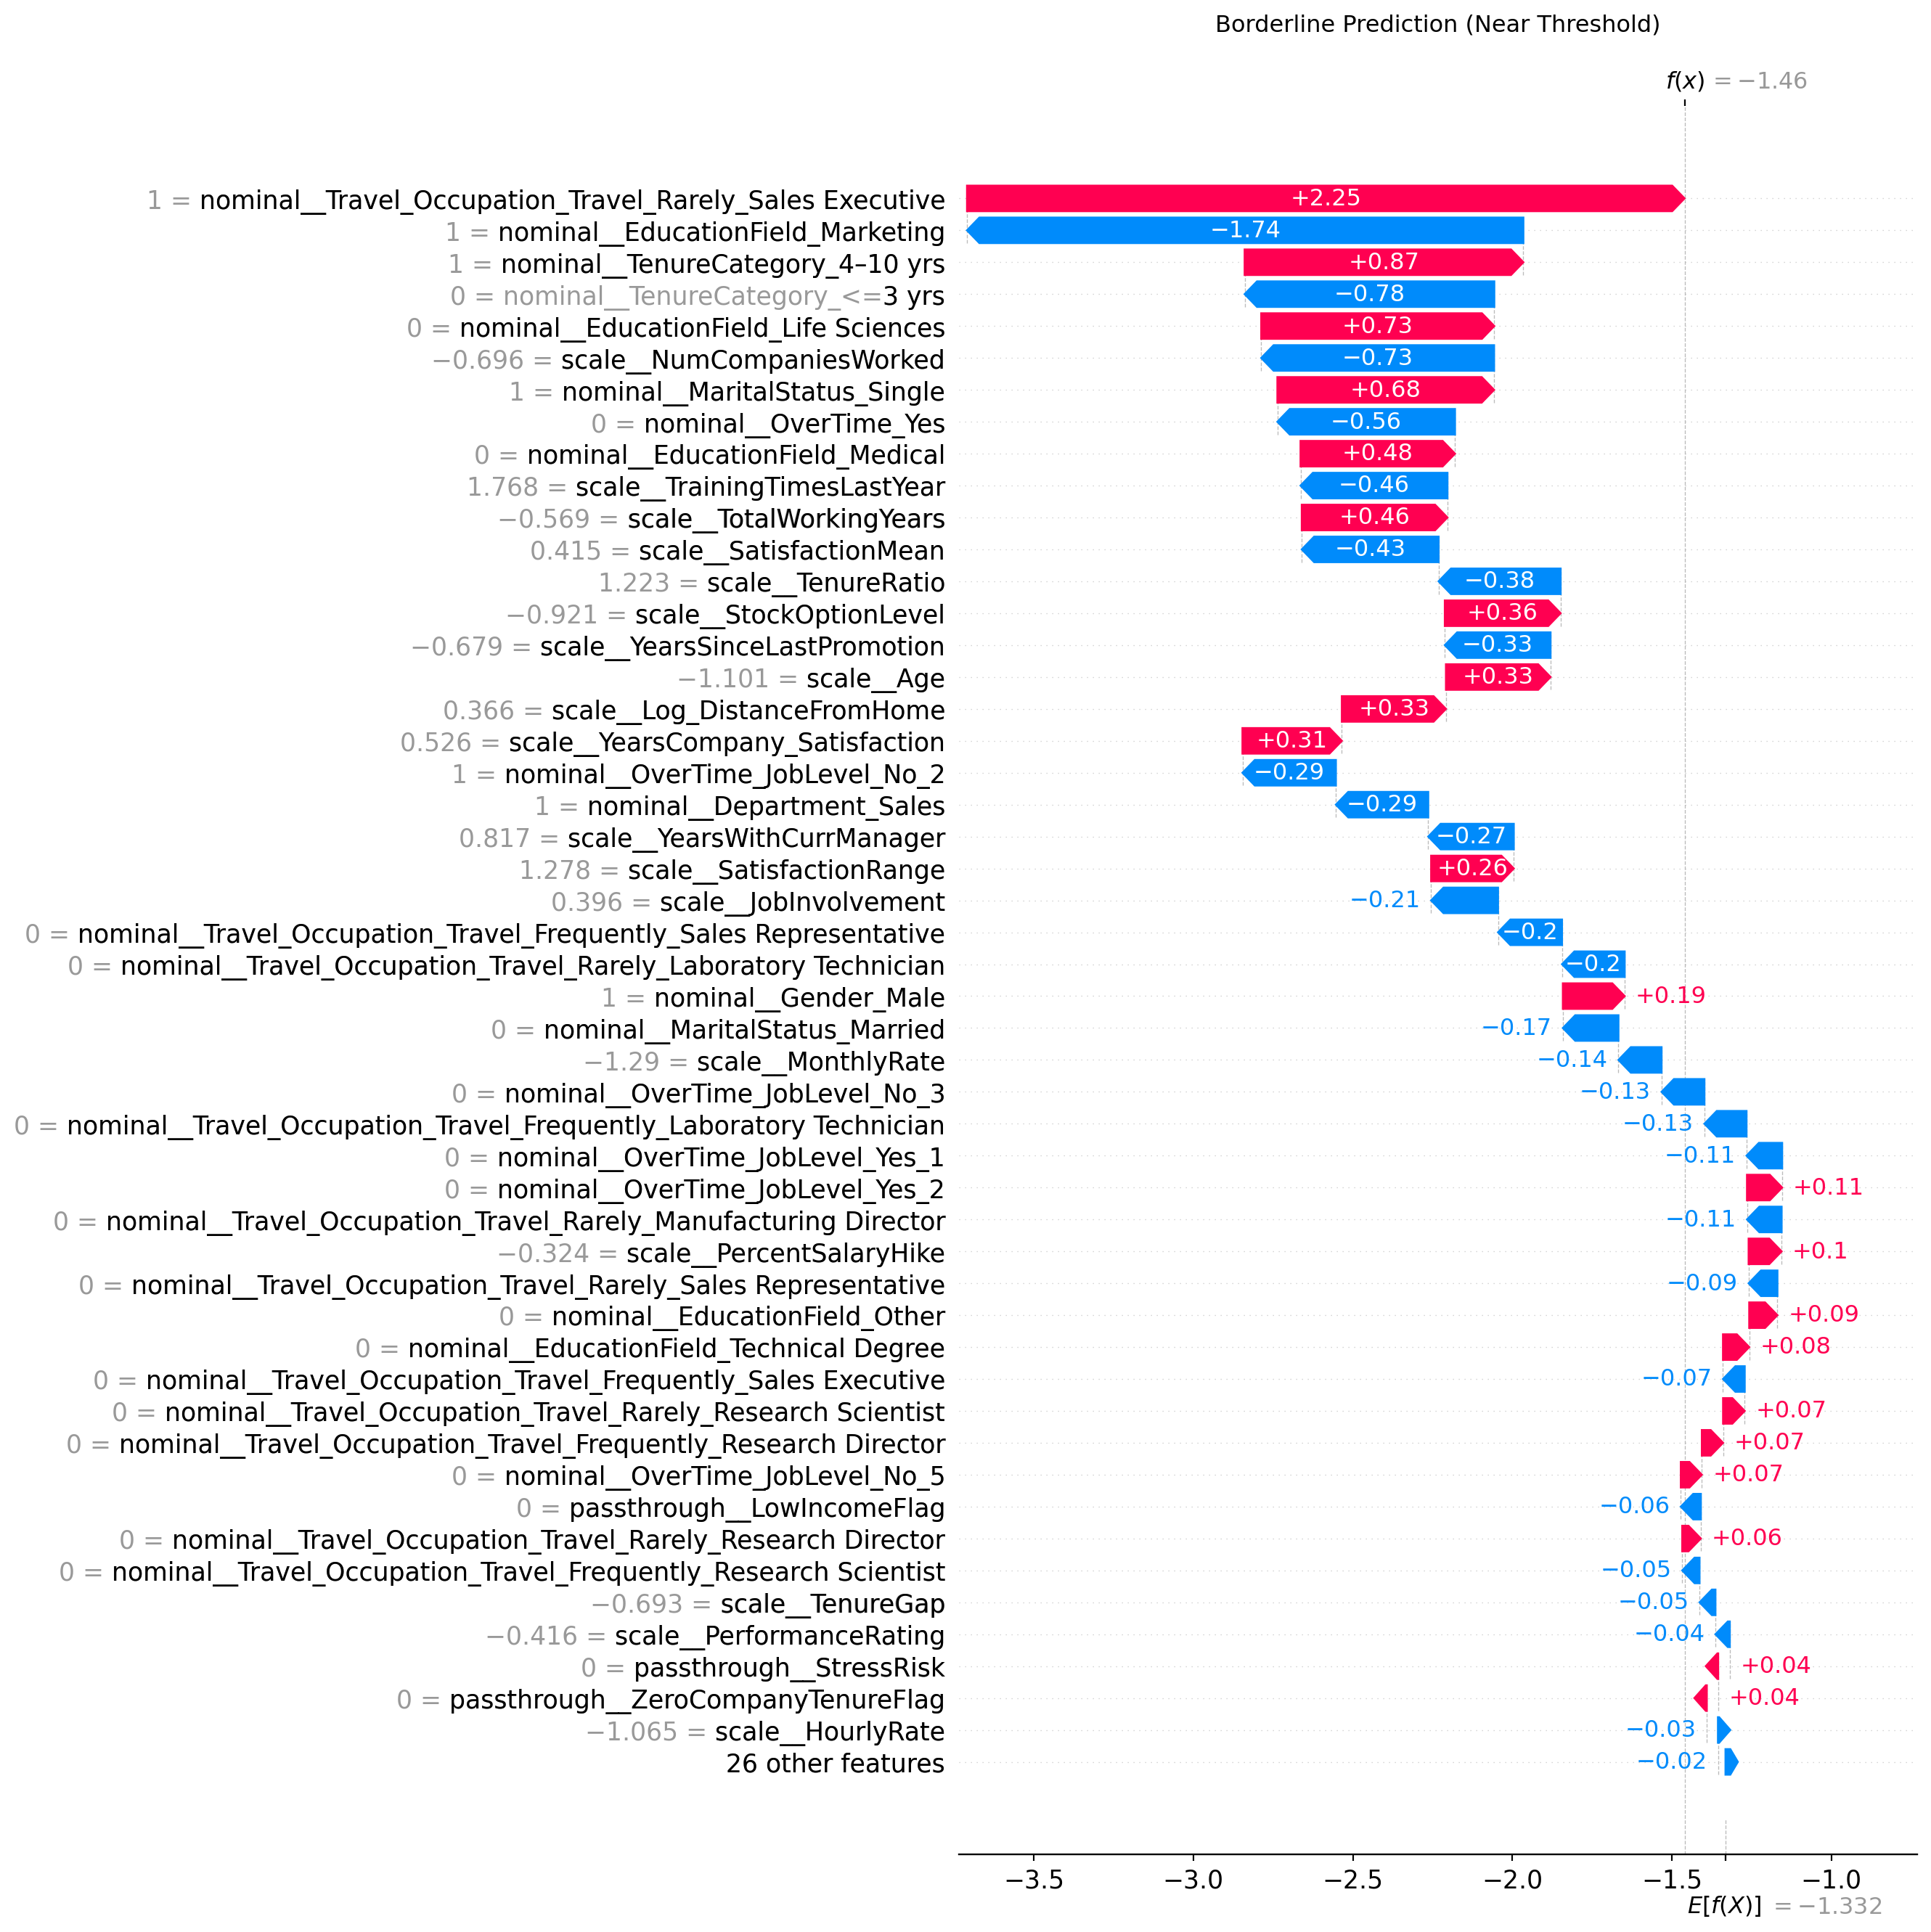

In [9]:
# Cell 3: Borderline Prediction (Near Threshold)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall
_ = shap.plots.waterfall(
    shap_values[i_borderline],  # precomputed SHAP values for median case
    max_display=50,
    show=False                  # suppress SHAP’s internal plt.show()
)

# 2) Grab SHAP’s figure & axes
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize for long labels
fig.set_size_inches(14, 14)

# 4) Shift margins so nothing gets squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Title with extra padding
ax.set_title("Borderline Prediction (Near Threshold)", pad=20)
plt.tight_layout()
# 6) Render
plt.show()


### Low-Risk Case (Most Confident Negative Prediction)

In contrast, this employee is confidently predicted to stay:

- Strong indicators of professional stability — including substantial **total working years**, a **managerial role**, and **recent salary increases** — collectively outweigh any potential risks. Interestingly, frequent travel has been shown to be an indicator of attrition, but perhaps travel is made to be more pleasurable for employees with managerial roles (first class tickets / accomodations, etc.) so it becomes a retaining factor instead.
- A shorter tenure (**≤3 years**) marginally elevates attrition risk, yet this minor negative influence is effectively neutralized by stronger positive signals.
- A particularly short commute and a lack of overtime demands contribute to the model's certainty that this individual will stay with the company.

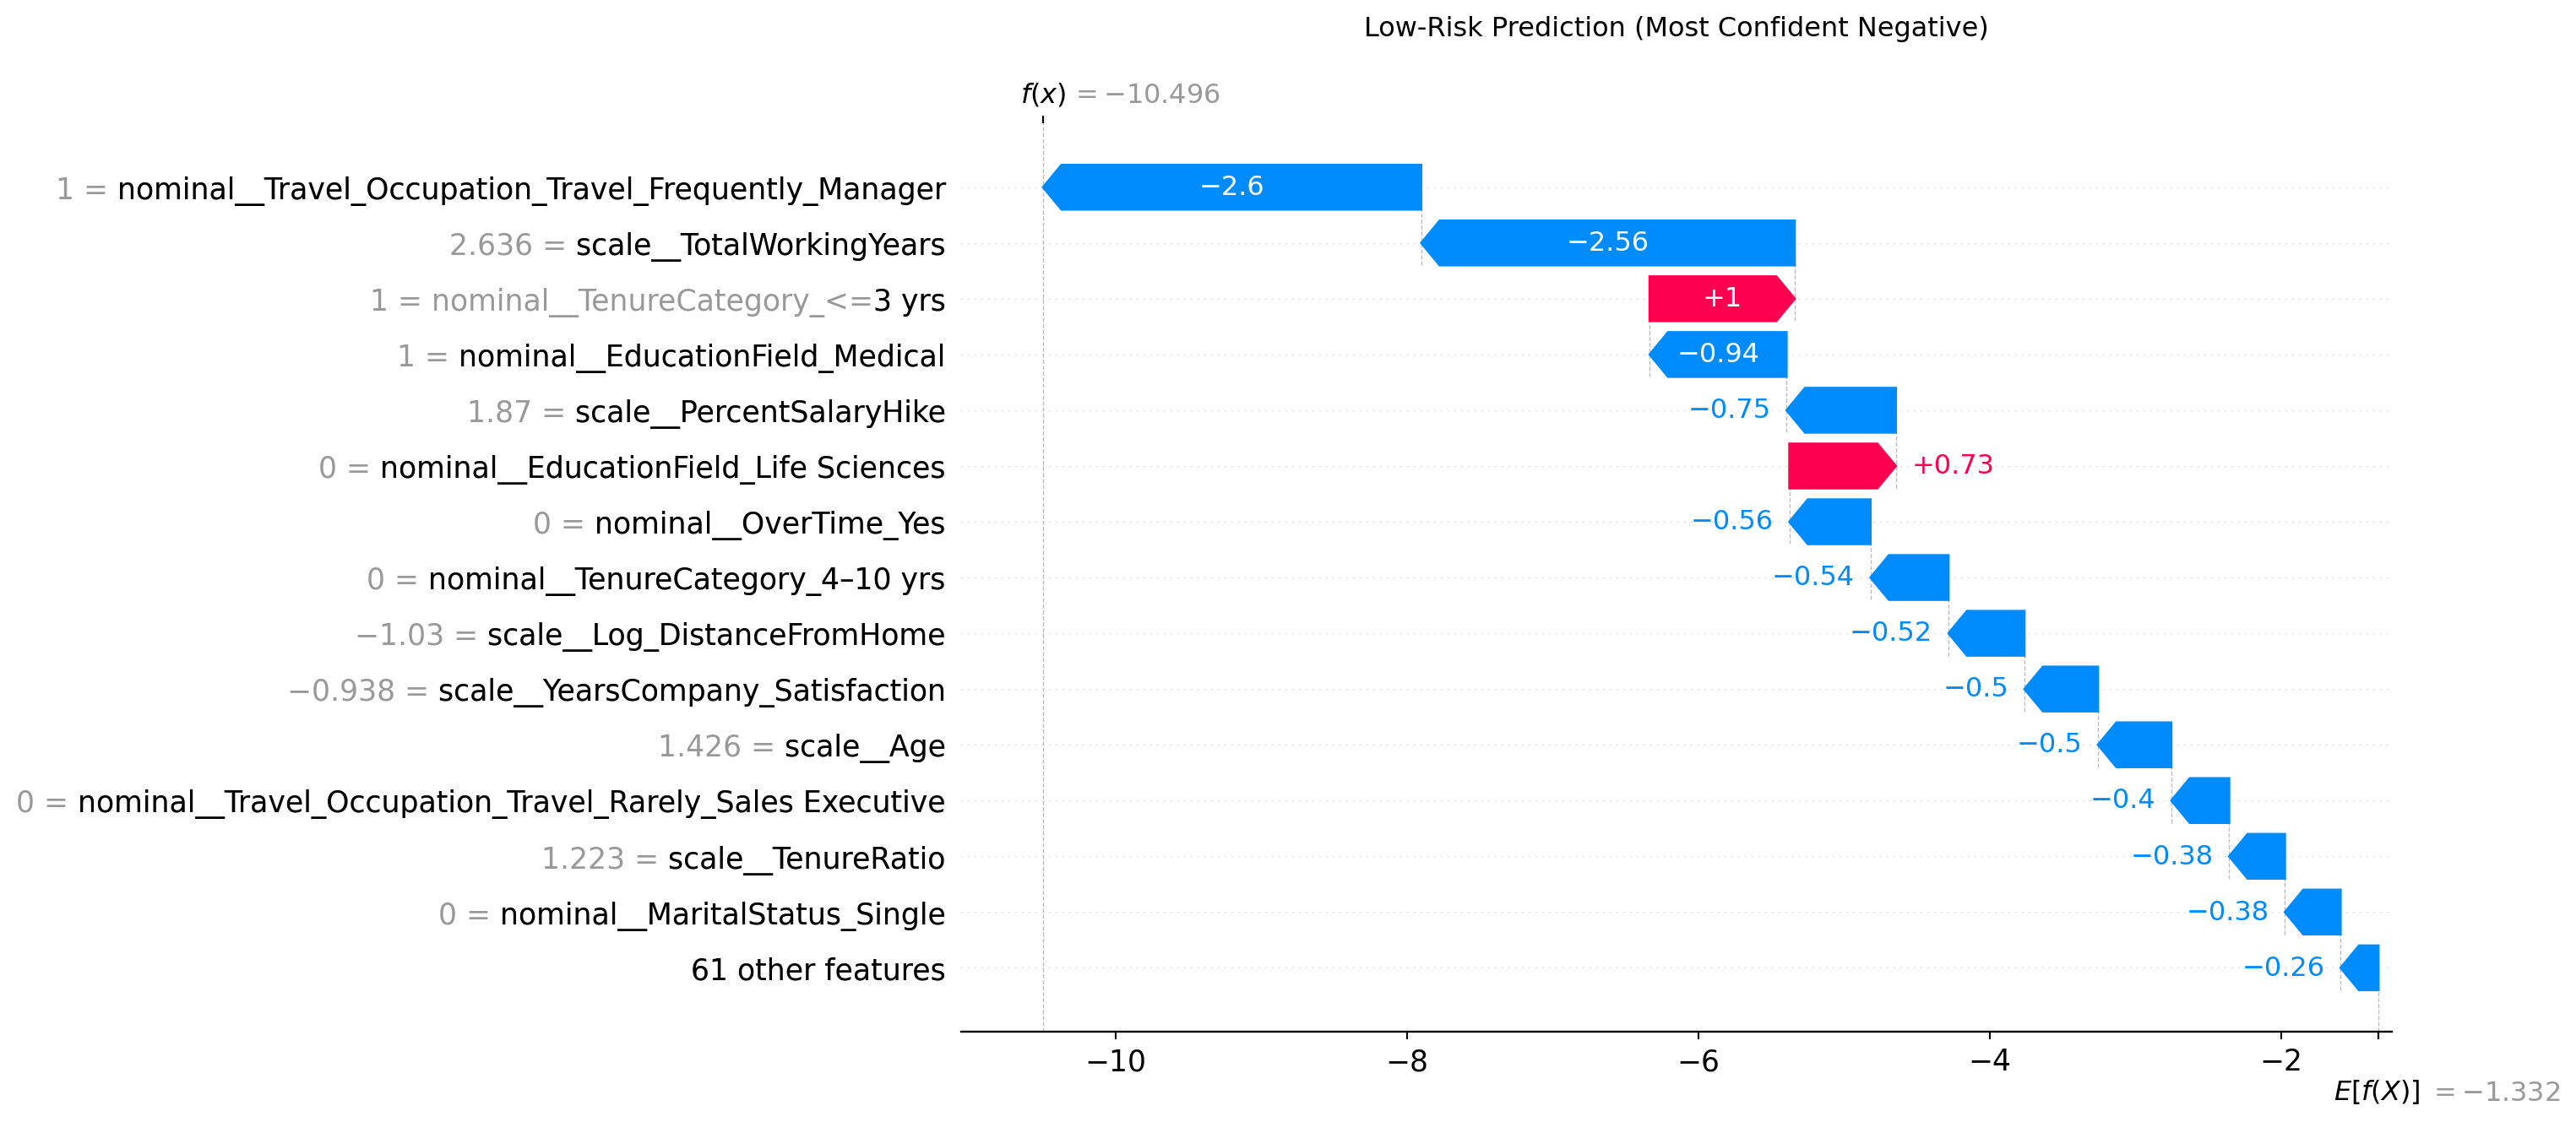

In [10]:
# Cell 4: Low-Risk Prediction (Most Confident Negative)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall
_ = shap.plots.waterfall(
    shap_values[i_low],  # precomputed SHAP values for safest case
    max_display=15,
    show=False           # suppress SHAP’s internal plt.show()
)

# 2) Grab SHAP’s figure & axes
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize for long labels
fig.set_size_inches(14, 7)

# 4) Shift margins so nothing gets squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Title with extra padding
ax.set_title("Low-Risk Prediction (Most Confident Negative)", pad=20)

# 6) Render
plt.show()


# 4. Coefficients
***

Logistic-regression coefficients give a clean, first-order view of the model’s logic—each value estimates how a one-unit change in a feature shifts the log-odds of attrition when everything else is held constant. Plotting the 20 largest coefficients (absolute value) lets us see inside the model before any non-linear interactions captured by SHAP.

- **Positive (red)**: Raises the log-odds of leaving (attrition risk) 
- **Negative (blue)**: Lowers the log-odds of leaving (retention signal) 

## Risk amplifiers  
- **Frequent-travel roles** (`Travel_Occupation_Travel_Frequently_*`) dominate the upper tier—burnout and time away from home remain powerful push factors.  
- **Overtime** (`OverTime_JobLevel_Yes_*` and `OverTime_Yes`) shows up repeatedly, underscoring workload pressure.  
- **Short tenure** (`TenureCategory_<=3 yrs`) confirms the classic early-exit pattern.

## Risk abators  
- **Specialised or technical education** (`EducationField_Technical Degree`, `EducationField_Other`) hints at stronger organisational fit and career paths.  
- **Non-travel managerial / HR positions** (`Non-Travel_*_Manager`, `*_Human Resources`) align with lower turnover, likely due to better work–life balance.  
- **Marketing & R&D specialists** post mild negative coefficients—role engagement can offset other stressors.

## Why This Matters Next to SHAP  
Coefficients nail down **direction and isolated strength**; SHAP (previous sections) adds **context and interaction effects**. The overlap—travel frequency, overtime, and early tenure—strengthens confidence that these are genuine, actionable signals.

**Bottom line:**  
Travel intensity and high workload sit at the heart of attrition risk, while specialised skills, managerial stability, and advanced education anchor employees. Coefficients and SHAP together give a consistent, multi-angle narrative to steer targeted retention strategies.

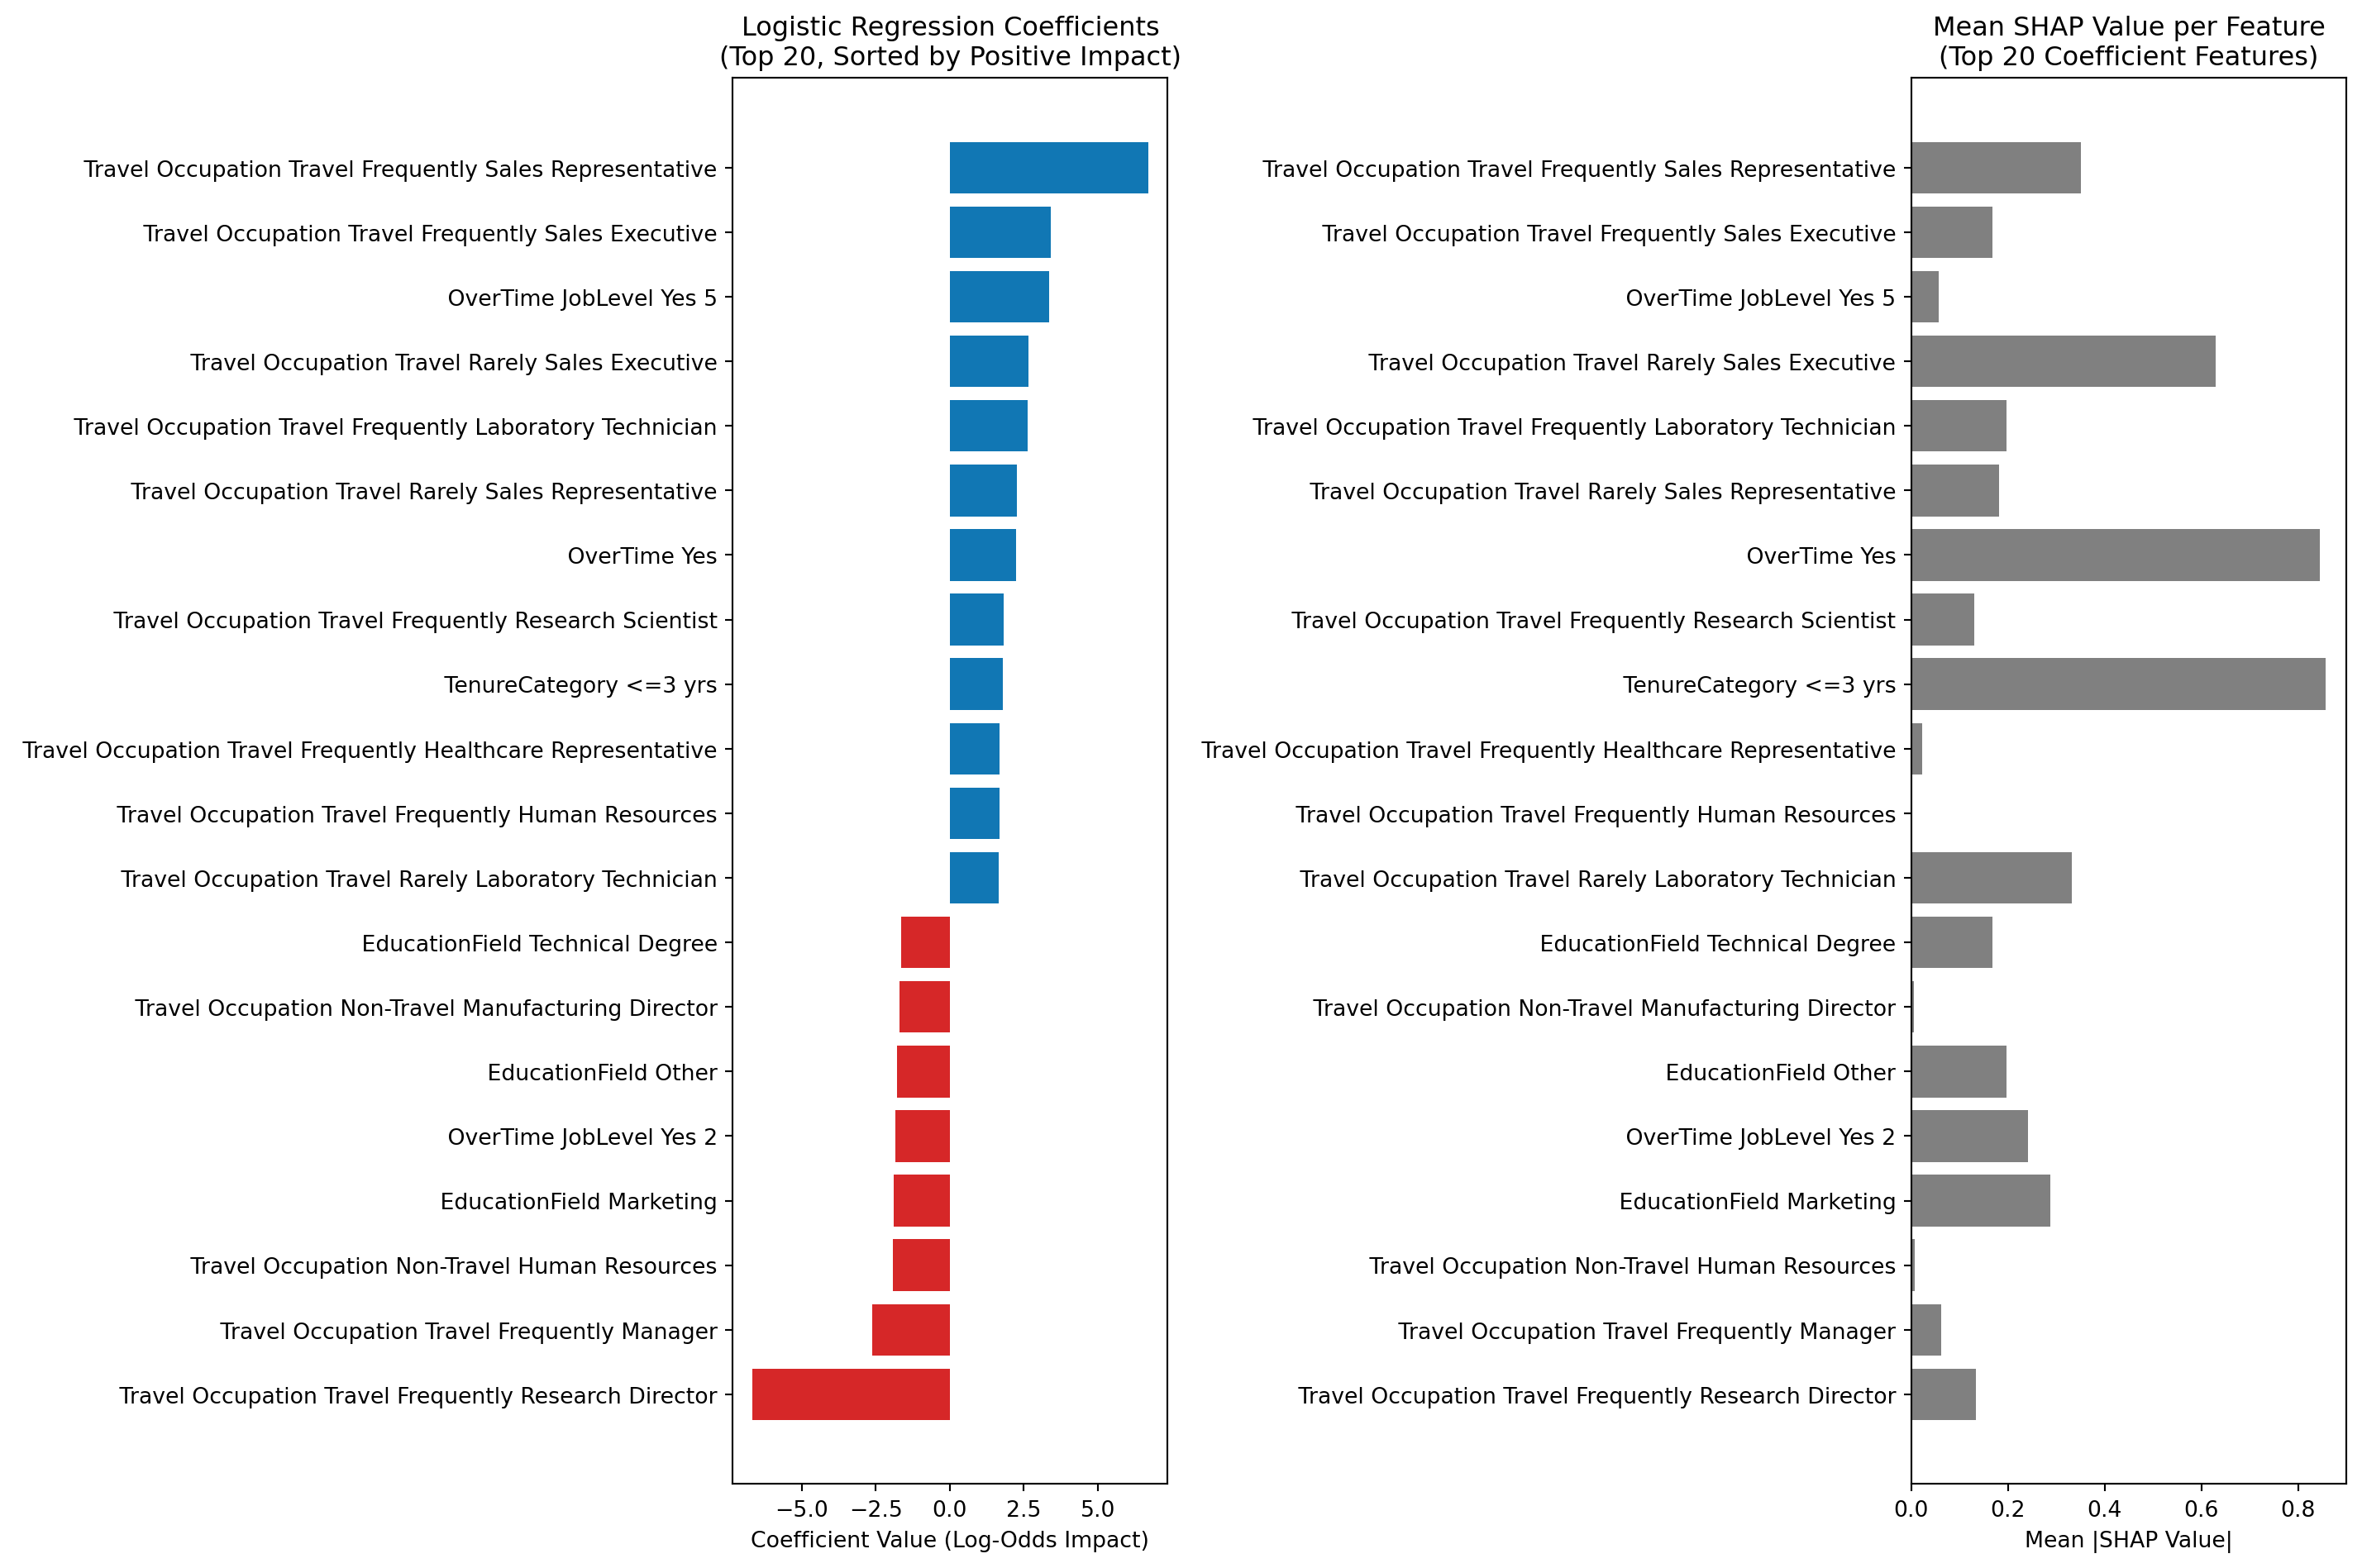

Model intercept: -3.605


In [11]:
# === Imports ===
import joblib
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import shap

# === Load Model, Data, and SHAP Values ===
classifier = joblib.load("../models/final_model.joblib")
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# === Clean Feature Names ===
def clean_name(name):
    return name.replace("nominal_", "").replace("scale_", "").replace("passthrough_", "").replace("_", " ")

# === SHAP Values ===
explainer = shap.Explainer(classifier, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

# === Coefficients from Model ===
coefs = classifier.coef_[0]
intercept = classifier.intercept_[0]

coef_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "Coefficient": coefs
})
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()

# === Grouping Logic ===
def extract_group(name):
    if "Travel" in name:
        return "Travel"
    elif "OverTime" in name:
        return "OverTime"
    elif "Department" in name:
        return "Department"
    elif "Satisfaction" in name or "Involvement" in name:
        return "Satisfaction"
    elif "JobRole" in name:
        return "Job Role"
    elif "Education" in name or "Field" in name:
        return "Education"
    elif "Income" in name or "Salary" in name or "Rate" in name:
        return "Compensation"
    elif "Years" in name or "Tenure" in name:
        return "Tenure"
    else:
        return "Other"

coef_df["Group"] = coef_df["Feature"].apply(extract_group)
coef_df["CleanFeature"] = coef_df["Feature"].apply(clean_name)

# === Top 20 Features by Coefficient Impact ===
top_coef_df = coef_df.sort_values(by="AbsCoefficient", ascending=False).head(20)
top_coef_df = top_coef_df.sort_values(by="Coefficient", ascending=False)

# === SHAP Mean Impact ===
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "MeanSHAP": mean_shap
})
shap_df["Group"] = shap_df["Feature"].apply(extract_group)
shap_df["CleanFeature"] = shap_df["Feature"].apply(clean_name)

# === Merge and keep clean labels ===
merged_df = pd.merge(top_coef_df, shap_df[["Feature", "MeanSHAP", "Group", "CleanFeature"]], on="Feature", how="left")
merged_df = merged_df.sort_values(by="Coefficient", ascending=False)

merged_df["CleanFeature"] = merged_df["Feature"].apply(clean_name)

# === Plot side by side ===
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Use the shared CleanFeature for both plots
labels = merged_df["CleanFeature"]

# --- Coefficient Plot ---
axes[0].barh(
    labels,
    merged_df["Coefficient"],
    color=["#1177b4" if c > 0 else "#d62728" for c in merged_df["Coefficient"]]
)
axes[0].set_title("Logistic Regression Coefficients\n(Top 20, Sorted by Positive Impact)")
axes[0].set_xlabel("Coefficient Value (Log-Odds Impact)")
axes[0].invert_yaxis()

# --- SHAP Plot ---
axes[1].barh(
    labels,
    merged_df["MeanSHAP"],
    color="gray"
)
axes[1].set_title("Mean SHAP Value per Feature\n(Top 20 Coefficient Features)")
axes[1].set_xlabel("Mean |SHAP Value|")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Optional: print model intercept
print(f"Model intercept: {intercept:.3f}")


# **Notebook Summary**
***

This notebook demonstrates how SHAP values and logistic regression coefficients can be combined to uncover not just **what** drives attrition, but **why** and **how** individual predictions emerge—offering clarity, transparency, and actionable insight.

At a global level, **frequent travel**, **overtime**, and **short tenure (≤3 years)** emerge as dominant risk factors, confirmed by both SHAP impact and model coefficients. These variables consistently push the model toward predicting attrition across many employees. Meanwhile, **professional stability signals**—such as long tenure, high satisfaction, technical education, and managerial roles—clearly lower the predicted risk of leaving.

The beeswarm SHAP plot reveals more nuanced dynamics:
- **Low satisfaction**, **low tenure**, and **high job-hopping history** increase risk.
- **High satisfaction**, **managerial stability**, and **career maturity** anchor employees.
- Younger employees are more likely to leave, while older employees are more likely to stay.

At the local level, SHAP waterfall plots expose the mechanisms behind specific decisions:
- In **high-risk cases**, attrition is driven by a potent combination of workload (overtime), instability (short tenure), and isolating roles (frequent travel).
- In **borderline cases**, opposing forces (travel risk vs. marketing background or tenure balance) nearly cancel each other, leading to decisions near the threshold.
- In **low-risk cases**, strong retention signals—like career growth, salary increases, and lack of burnout—overwhelm any mild red flags.

The **threshold sensitivity analysis** further supports the model’s practical relevance. Adjusting the threshold allows trade-offs between outreach scope and missed true attritions, giving HR teams flexibility based on tolerance for false positives or negatives.

Together, this layered approach creates a **decision-support system**:
- Coefficients offer direction and strength.
- SHAP values provide interaction-aware transparency.
- Case-level plots connect predictions to human narratives.
- Business teams can now **see**, **weigh**, and **act** on model-driven insights.

This level of interpretability empowers stakeholders to move from intuition to informed strategy—whether it's targeted retention efforts, better career pathing, or smarter workload distribution.